In [32]:
import scanpy as sc
import squidpy as sq
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage.color import label2rgb
from skimage.measure import regionprops_table

In [4]:
from stardist.models import StarDist2D
from csbdeep.utils import normalize

2022-10-03 13:57:54.942698: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-10-03 13:57:55.127853: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-10-03 13:57:55.838486: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-10-03 13:57:55.838620: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: 

In [5]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

2022-10-03 13:58:39.052719: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudnn.so.8'; dlerror: libcudnn.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-10-03 13:58:39.053342: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1934] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


[]

#### load data

In [2]:
a = sc.read_h5ad('../data/pdac/HT270P1-S1H1U1/adata.h5ad')
a

AnnData object with n_obs × n_vars = 3940 × 17943
    obs: 'in_tissue', 'array_row', 'array_col', 'clusters', 'spot_index'
    var: 'gene_ids', 'feature_types', 'genome', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'full_res_he', 'hvg', 'leiden', 'log1p', 'neighbors', 'pca', 'rescaled_he', 'rescaled_spot_masks', 'rescaled_spot_metadata', 'spatial', 'trimmed', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial', 'spatial_16X_notrim', 'spatial_16X_trimmed', 'spatial_1X_notrim', 'spatial_1X_trimmed', 'spatial_2X_notrim', 'spatial_2X_trimmed', 'spatial_4X_notrim', 'spatial_4X_trimmed', 'spatial_8X_notrim', 'spatial_8X_trimmed', 'spatial_trimmed'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

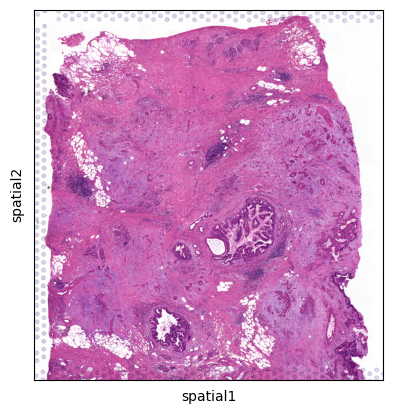

In [3]:
sc.pl.spatial(a)

In [6]:
a.uns['rescaled_he'].keys()

dict_keys(['16X_notrim', '16X_trimmed', '1X_notrim', '1X_trimmed', '2X_notrim', '2X_trimmed', '4X_notrim', '4X_trimmed', '512x512_notrim', '512x512_trimmed', '8X_notrim', '8X_trimmed'])

In [7]:
hires_he_img = a.uns['rescaled_he']['1X_trimmed']
hires_he_img.shape

(15936, 15049, 3)

In [14]:
hires_he_img = hires_he_img[4000:5000, 4000:5000]

In [15]:
img = sq.im.ImageContainer(hires_he_img, layer="image")

#### segmentation

In [9]:
def stardist_2D_versatile_he(img, nms_thresh=None, prob_thresh=None):
    #axis_norm = (0,1)   # normalize channels independently
    axis_norm = (0,1,2) # normalize channels jointly
    # Make sure to normalize the input image beforehand or supply a normalizer to the prediction function.
    # this is the default normalizer noted in StarDist examples.
    img = normalize(img, 1, 99.8, axis=axis_norm)
    model = StarDist2D.from_pretrained('2D_versatile_he')
    labels, _ = model.predict_instances(img, nms_thresh=nms_thresh, prob_thresh=prob_thresh)
    return labels

In [10]:
StarDist2D.from_pretrained('2D_versatile_he')

Found model '2D_versatile_he' for 'StarDist2D'.
5294730/5294730 [==============================] - 0s 0us/step


2022-10-03 14:03:52.522767: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


StarDist2D(2D_versatile_he): YXC → YXC
├─ Directory: None
└─ Config2D(n_dim=2, axes='YXC', n_channel_in=3, n_channel_out=33, train_checkpoint='weights_best.h5', train_checkpoint_last='weights_last.h5', train_checkpoint_epoch='weights_now.h5', n_rays=32, grid=(2, 2), backbone='unet', n_classes=None, unet_n_depth=3, unet_kernel_size=[3, 3], unet_n_filter_base=32, unet_n_conv_per_depth=2, unet_pool=[2, 2], unet_activation='relu', unet_last_activation='relu', unet_batch_norm=False, unet_dropout=0.0, unet_prefix='', net_conv_after_unet=128, net_input_shape=[None, None, 3], net_mask_shape=[None, None, 1], train_shape_completion=False, train_completion_crop=32, train_patch_size=[512, 512], train_background_reg=0.0001, train_foreground_only=0.9, train_sample_cache=True, train_dist_loss='mae', train_loss_weights=[1, 0.1], train_class_weights=(1, 1), train_epochs=200, train_steps_per_epoch=200, train_learning_rate=0.0003, train_batch_size=8, train_n_val_patches=3, train_tensorboard=True, train_r

In [11]:
def stardist_2D_versatile_he(img, nms_thresh=None, prob_thresh=None):
    #axis_norm = (0,1)   # normalize channels independently
    axis_norm = (0,1,2) # normalize channels jointly
    # Make sure to normalize the input image beforehand or supply a normalizer to the prediction function.
    # this is the default normalizer noted in StarDist examples.
    img = normalize(img, 1, 99.8, axis=axis_norm)
    model = StarDist2D.from_pretrained('2D_versatile_he')
    labels, _ = model.predict_instances(img, n_tiles=(10, 10, 1), nms_thresh=nms_thresh, prob_thresh=prob_thresh)
    return labels

In [12]:
model = StarDist2D.from_pretrained('2D_versatile_he')

Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.


In [20]:
%%time
sq.im.segment(
    img=img,
    layer="image",
    channel=None,
    method=stardist_2D_versatile_he,
    layer_added='segmented_stardist_default',
    prob_thresh=.2,
    nms_thresh=None
)

Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.
1/1 [==============================] - 0s 49ms/step


  0%|                                                                                                                                                                                                                            | 0/121 [00:00<?, ?it/s]

1/1 [==============================] - 0s 211ms/step


  1%|█▊                                                                                                                                                                                                                  | 1/121 [00:00<00:29,  4.02it/s]

1/1 [==============================] - 0s 56ms/step


  2%|█████▎                                                                                                                                                                                                              | 3/121 [00:00<00:16,  7.29it/s]

1/1 [==============================] - 0s 46ms/step


  4%|████████▊                                                                                                                                                                                                           | 5/121 [00:00<00:13,  8.82it/s]

1/1 [==============================] - 0s 52ms/step


  6%|████████████▎                                                                                                                                                                                                       | 7/121 [00:00<00:11,  9.53it/s]

1/1 [==============================] - 0s 49ms/step


  7%|███████████████▊                                                                                                                                                                                                    | 9/121 [00:00<00:10, 10.27it/s]

1/1 [==============================] - 0s 45ms/step


  9%|███████████████████▏                                                                                                                                                                                               | 11/121 [00:01<00:10, 10.88it/s]

1/1 [==============================] - 0s 52ms/step


 11%|██████████████████████▋                                                                                                                                                                                            | 13/121 [00:01<00:09, 10.84it/s]

1/1 [==============================] - 0s 46ms/step


 12%|██████████████████████████▏                                                                                                                                                                                        | 15/121 [00:01<00:09, 11.19it/s]

1/1 [==============================] - 0s 48ms/step


 14%|█████████████████████████████▋                                                                                                                                                                                     | 17/121 [00:01<00:09, 11.48it/s]

1/1 [==============================] - 0s 47ms/step


 16%|█████████████████████████████████▏                                                                                                                                                                                 | 19/121 [00:01<00:08, 11.74it/s]

1/1 [==============================] - 0s 54ms/step


 17%|████████████████████████████████████▌                                                                                                                                                                              | 21/121 [00:02<00:08, 11.32it/s]

1/1 [==============================] - 0s 56ms/step


 19%|████████████████████████████████████████                                                                                                                                                                           | 23/121 [00:02<00:08, 11.27it/s]

1/1 [==============================] - 0s 47ms/step


 21%|███████████████████████████████████████████▌                                                                                                                                                                       | 25/121 [00:02<00:08, 11.52it/s]

1/1 [==============================] - 0s 52ms/step


 22%|███████████████████████████████████████████████                                                                                                                                                                    | 27/121 [00:02<00:08, 11.28it/s]

1/1 [==============================] - 0s 47ms/step


 24%|██████████████████████████████████████████████████▌                                                                                                                                                                | 29/121 [00:02<00:08, 11.47it/s]

1/1 [==============================] - 0s 47ms/step


 26%|██████████████████████████████████████████████████████                                                                                                                                                             | 31/121 [00:02<00:07, 11.44it/s]

1/1 [==============================] - 0s 47ms/step


 27%|█████████████████████████████████████████████████████████▌                                                                                                                                                         | 33/121 [00:03<00:07, 11.56it/s]

1/1 [==============================] - 0s 46ms/step


 29%|█████████████████████████████████████████████████████████████                                                                                                                                                      | 35/121 [00:03<00:07, 11.79it/s]

1/1 [==============================] - 0s 56ms/step


 31%|████████████████████████████████████████████████████████████████▌                                                                                                                                                  | 37/121 [00:03<00:07, 11.51it/s]

1/1 [==============================] - 0s 52ms/step


 32%|████████████████████████████████████████████████████████████████████                                                                                                                                               | 39/121 [00:03<00:07, 11.53it/s]

1/1 [==============================] - 0s 50ms/step


 34%|███████████████████████████████████████████████████████████████████████▍                                                                                                                                           | 41/121 [00:03<00:09,  8.53it/s]

1/1 [==============================] - 0s 49ms/step


 36%|██████████████████████████████████████████████████████████████████████████▉                                                                                                                                        | 43/121 [00:04<00:08,  9.33it/s]

1/1 [==============================] - 0s 54ms/step


 37%|██████████████████████████████████████████████████████████████████████████████▍                                                                                                                                    | 45/121 [00:04<00:07,  9.92it/s]

1/1 [==============================] - 0s 48ms/step


 39%|█████████████████████████████████████████████████████████████████████████████████▉                                                                                                                                 | 47/121 [00:04<00:07, 10.50it/s]

1/1 [==============================] - 0s 51ms/step


 40%|█████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                             | 49/121 [00:04<00:06, 10.82it/s]

1/1 [==============================] - 0s 54ms/step


 42%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                          | 51/121 [00:04<00:06, 10.88it/s]

1/1 [==============================] - 0s 53ms/step


 44%|████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                      | 53/121 [00:04<00:06, 11.19it/s]

1/1 [==============================] - 0s 46ms/step


 45%|███████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                   | 55/121 [00:05<00:05, 11.42it/s]

1/1 [==============================] - 0s 53ms/step


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                               | 57/121 [00:05<00:05, 11.30it/s]

1/1 [==============================] - 0s 47ms/step


 49%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                            | 59/121 [00:05<00:05, 11.13it/s]

1/1 [==============================] - 0s 49ms/step


 50%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                        | 61/121 [00:05<00:05, 11.29it/s]

1/1 [==============================] - 0s 45ms/step


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                     | 63/121 [00:05<00:04, 11.63it/s]

1/1 [==============================] - 0s 53ms/step


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                 | 65/121 [00:06<00:04, 11.60it/s]

1/1 [==============================] - 0s 49ms/step


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                              | 67/121 [00:06<00:04, 11.70it/s]

1/1 [==============================] - 0s 48ms/step


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 69/121 [00:06<00:04, 11.68it/s]

1/1 [==============================] - 0s 48ms/step


 59%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                       | 71/121 [00:06<00:04, 11.77it/s]

1/1 [==============================] - 0s 45ms/step


 60%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                   | 73/121 [00:06<00:04, 11.91it/s]

1/1 [==============================] - 0s 47ms/step


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 75/121 [00:06<00:03, 12.11it/s]

1/1 [==============================] - 0s 47ms/step


 64%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                            | 77/121 [00:07<00:03, 12.18it/s]

1/1 [==============================] - 0s 48ms/step


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                         | 79/121 [00:07<00:03, 12.02it/s]

1/1 [==============================] - 0s 50ms/step


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                     | 81/121 [00:07<00:03, 11.96it/s]

1/1 [==============================] - 0s 48ms/step


 69%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                  | 83/121 [00:07<00:03, 11.67it/s]

1/1 [==============================] - 0s 47ms/step


 70%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                              | 85/121 [00:07<00:03, 11.78it/s]

1/1 [==============================] - 0s 48ms/step


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 87/121 [00:07<00:02, 11.91it/s]

1/1 [==============================] - 0s 53ms/step


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                       | 89/121 [00:08<00:02, 11.67it/s]

1/1 [==============================] - 0s 47ms/step


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                    | 91/121 [00:08<00:02, 11.83it/s]

1/1 [==============================] - 0s 45ms/step


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                | 93/121 [00:08<00:02, 11.96it/s]

1/1 [==============================] - 0s 49ms/step


 79%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                             | 95/121 [00:08<00:02, 11.84it/s]

1/1 [==============================] - 0s 49ms/step


 80%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                         | 97/121 [00:08<00:02, 11.78it/s]

1/1 [==============================] - 0s 48ms/step


 82%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                      | 99/121 [00:08<00:01, 11.85it/s]

1/1 [==============================] - 0s 50ms/step


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 101/121 [00:09<00:01, 11.70it/s]

1/1 [==============================] - 0s 52ms/step


 85%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 103/121 [00:09<00:01, 11.58it/s]

1/1 [==============================] - 0s 53ms/step


 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 105/121 [00:09<00:01, 11.34it/s]

1/1 [==============================] - 0s 51ms/step


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                        | 107/121 [00:09<00:01, 11.24it/s]

1/1 [==============================] - 0s 50ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                    | 109/121 [00:09<00:01, 11.24it/s]

1/1 [==============================] - 0s 55ms/step


 92%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                 | 111/121 [00:09<00:00, 11.31it/s]

1/1 [==============================] - 0s 48ms/step


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████              | 113/121 [00:10<00:00, 11.41it/s]

1/1 [==============================] - 0s 54ms/step


 95%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌          | 115/121 [00:10<00:00, 11.14it/s]

1/1 [==============================] - 0s 49ms/step


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████       | 117/121 [00:10<00:00, 11.09it/s]

1/1 [==============================] - 0s 53ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌   | 119/121 [00:10<00:00, 11.21it/s]

1/1 [==============================] - 0s 50ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 121/121 [00:10<00:00, 11.16it/s]


CPU times: user 10min 52s, sys: 31.8 s, total: 11min 24s
Wall time: 19.5 s


In [21]:
x = np.asarray(img['segmented_stardist_default'].as_numpy().squeeze())

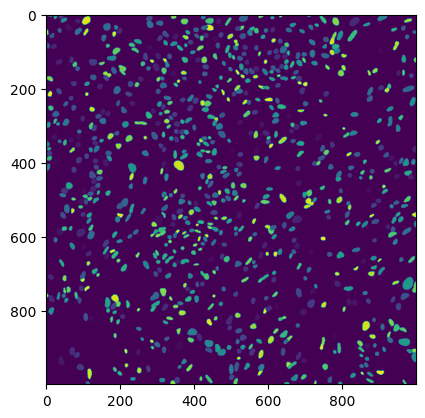

In [22]:
plt.imshow(x)

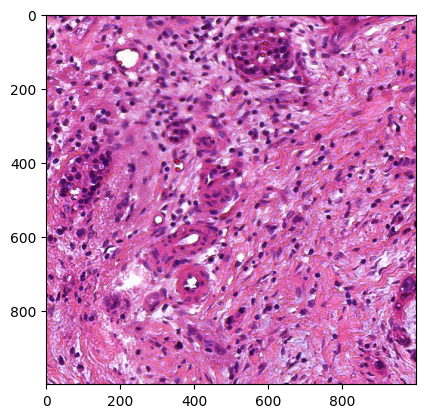

In [23]:
plt.imshow(hires_he_img)

In [25]:
%%time
img = sq.im.ImageContainer(a.uns['rescaled_he']['1X_trimmed'], layer="image")
sq.im.segment(
    img=img,
    layer="image",
    channel=None,
    method=stardist_2D_versatile_he,
    layer_added='segmented_stardist_default',
    prob_thresh=.2,
    nms_thresh=None
)

Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.
1/1 [==============================] - 0s 42ms/step


  0%|                                                                                                                                                                                                                            | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 1s 584ms/step


  1%|██                                                                                                                                                                                                                  | 1/100 [00:00<01:15,  1.31it/s]

1/1 [==============================] - 0s 423ms/step


  2%|████▏                                                                                                                                                                                                               | 2/100 [00:01<01:02,  1.56it/s]

1/1 [==============================] - 0s 427ms/step


  3%|██████▎                                                                                                                                                                                                             | 3/100 [00:01<00:58,  1.65it/s]

1/1 [==============================] - 0s 430ms/step


  4%|████████▍                                                                                                                                                                                                           | 4/100 [00:02<00:56,  1.69it/s]

1/1 [==============================] - 0s 410ms/step


  5%|██████████▌                                                                                                                                                                                                         | 5/100 [00:03<00:55,  1.73it/s]

1/1 [==============================] - 0s 474ms/step


  6%|████████████▋                                                                                                                                                                                                       | 6/100 [00:03<00:55,  1.68it/s]

1/1 [==============================] - 0s 411ms/step


  7%|██████████████▊                                                                                                                                                                                                     | 7/100 [00:04<00:54,  1.72it/s]

1/1 [==============================] - 0s 415ms/step


  8%|████████████████▉                                                                                                                                                                                                   | 8/100 [00:04<00:52,  1.75it/s]

1/1 [==============================] - 0s 407ms/step


  9%|███████████████████                                                                                                                                                                                                 | 9/100 [00:05<00:51,  1.75it/s]

1/1 [==============================] - 0s 405ms/step


 10%|█████████████████████                                                                                                                                                                                              | 10/100 [00:05<00:50,  1.79it/s]

1/1 [==============================] - 0s 420ms/step


 11%|███████████████████████▏                                                                                                                                                                                           | 11/100 [00:06<00:51,  1.72it/s]

1/1 [==============================] - 0s 422ms/step


 12%|█████████████████████████▎                                                                                                                                                                                         | 12/100 [00:07<00:50,  1.74it/s]

1/1 [==============================] - 0s 422ms/step


 13%|███████████████████████████▍                                                                                                                                                                                       | 13/100 [00:07<00:49,  1.76it/s]

1/1 [==============================] - 0s 414ms/step


 14%|█████████████████████████████▌                                                                                                                                                                                     | 14/100 [00:08<00:48,  1.77it/s]

1/1 [==============================] - 0s 424ms/step


 15%|███████████████████████████████▋                                                                                                                                                                                   | 15/100 [00:08<00:48,  1.76it/s]

1/1 [==============================] - 0s 428ms/step


 16%|█████████████████████████████████▊                                                                                                                                                                                 | 16/100 [00:09<00:47,  1.75it/s]

1/1 [==============================] - 0s 413ms/step


 17%|███████████████████████████████████▊                                                                                                                                                                               | 17/100 [00:09<00:47,  1.75it/s]

1/1 [==============================] - 0s 413ms/step


 18%|█████████████████████████████████████▉                                                                                                                                                                             | 18/100 [00:10<00:46,  1.75it/s]

1/1 [==============================] - 0s 442ms/step


 19%|████████████████████████████████████████                                                                                                                                                                           | 19/100 [00:11<00:46,  1.74it/s]

1/1 [==============================] - 0s 456ms/step


 20%|██████████████████████████████████████████▏                                                                                                                                                                        | 20/100 [00:11<00:46,  1.72it/s]

1/1 [==============================] - 0s 436ms/step


 21%|████████████████████████████████████████████▎                                                                                                                                                                      | 21/100 [00:12<00:46,  1.68it/s]

1/1 [==============================] - 0s 431ms/step


 22%|██████████████████████████████████████████████▍                                                                                                                                                                    | 22/100 [00:12<00:46,  1.69it/s]

1/1 [==============================] - 0s 424ms/step


 23%|████████████████████████████████████████████████▌                                                                                                                                                                  | 23/100 [00:13<00:45,  1.69it/s]

1/1 [==============================] - 0s 439ms/step


 24%|██████████████████████████████████████████████████▋                                                                                                                                                                | 24/100 [00:14<00:44,  1.69it/s]

1/1 [==============================] - 0s 428ms/step


 25%|████████████████████████████████████████████████████▊                                                                                                                                                              | 25/100 [00:14<00:44,  1.70it/s]

1/1 [==============================] - 0s 417ms/step


 26%|██████████████████████████████████████████████████████▊                                                                                                                                                            | 26/100 [00:15<00:43,  1.71it/s]

1/1 [==============================] - 0s 438ms/step


 27%|████████████████████████████████████████████████████████▉                                                                                                                                                          | 27/100 [00:15<00:43,  1.69it/s]

1/1 [==============================] - 0s 422ms/step


 28%|███████████████████████████████████████████████████████████                                                                                                                                                        | 28/100 [00:16<00:42,  1.70it/s]

1/1 [==============================] - 0s 419ms/step


 29%|█████████████████████████████████████████████████████████████▏                                                                                                                                                     | 29/100 [00:16<00:41,  1.72it/s]

1/1 [==============================] - 0s 426ms/step


 30%|███████████████████████████████████████████████████████████████▎                                                                                                                                                   | 30/100 [00:17<00:40,  1.74it/s]

1/1 [==============================] - 0s 421ms/step


 31%|█████████████████████████████████████████████████████████████████▍                                                                                                                                                 | 31/100 [00:18<00:39,  1.73it/s]

1/1 [==============================] - 1s 594ms/step


 32%|███████████████████████████████████████████████████████████████████▌                                                                                                                                               | 32/100 [00:18<00:42,  1.60it/s]

1/1 [==============================] - 0s 424ms/step


 33%|█████████████████████████████████████████████████████████████████████▋                                                                                                                                             | 33/100 [00:19<00:40,  1.65it/s]

1/1 [==============================] - 0s 424ms/step


 34%|███████████████████████████████████████████████████████████████████████▋                                                                                                                                           | 34/100 [00:19<00:39,  1.68it/s]

1/1 [==============================] - 0s 419ms/step


 35%|█████████████████████████████████████████████████████████████████████████▊                                                                                                                                         | 35/100 [00:20<00:38,  1.71it/s]

1/1 [==============================] - 0s 413ms/step


 36%|███████████████████████████████████████████████████████████████████████████▉                                                                                                                                       | 36/100 [00:21<00:37,  1.70it/s]

1/1 [==============================] - 0s 408ms/step


 37%|██████████████████████████████████████████████████████████████████████████████                                                                                                                                     | 37/100 [00:21<00:36,  1.74it/s]

1/1 [==============================] - 0s 411ms/step


 38%|████████████████████████████████████████████████████████████████████████████████▏                                                                                                                                  | 38/100 [00:22<00:35,  1.76it/s]

1/1 [==============================] - 0s 424ms/step


 39%|██████████████████████████████████████████████████████████████████████████████████▎                                                                                                                                | 39/100 [00:22<00:34,  1.76it/s]

1/1 [==============================] - 0s 406ms/step


 40%|████████████████████████████████████████████████████████████████████████████████████▍                                                                                                                              | 40/100 [00:23<00:33,  1.80it/s]

1/1 [==============================] - 0s 457ms/step


 41%|██████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                            | 41/100 [00:23<00:34,  1.71it/s]

1/1 [==============================] - 0s 423ms/step


 42%|████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                                          | 42/100 [00:24<00:33,  1.72it/s]

1/1 [==============================] - 1s 511ms/step


 43%|██████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                                        | 43/100 [00:25<00:34,  1.67it/s]

1/1 [==============================] - 2s 2s/step


 44%|████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                                      | 44/100 [00:27<01:03,  1.14s/it]

1/1 [==============================] - 0s 415ms/step


 45%|██████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                                    | 45/100 [00:28<00:52,  1.04it/s]

1/1 [==============================] - 1s 501ms/step


 46%|█████████████████████████████████████████████████████████████████████████████████████████████████                                                                                                                  | 46/100 [00:28<00:47,  1.14it/s]

1/1 [==============================] - 1s 559ms/step


 47%|███████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                                               | 47/100 [00:29<00:43,  1.21it/s]

1/1 [==============================] - 4s 4s/step


 48%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                                             | 48/100 [00:33<01:37,  1.87s/it]

1/1 [==============================] - 1s 533ms/step


 49%|███████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                                           | 49/100 [00:34<01:17,  1.51s/it]

1/1 [==============================] - 0s 410ms/step


 50%|█████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                         | 50/100 [00:34<01:00,  1.22s/it]

1/1 [==============================] - 0s 420ms/step


 51%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                                       | 51/100 [00:35<00:50,  1.03s/it]

1/1 [==============================] - 0s 417ms/step


 52%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                                     | 52/100 [00:36<00:43,  1.12it/s]

1/1 [==============================] - 0s 412ms/step


 53%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                                   | 53/100 [00:36<00:37,  1.26it/s]

1/1 [==============================] - 0s 413ms/step


 54%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                                                 | 54/100 [00:37<00:33,  1.38it/s]

1/1 [==============================] - 0s 417ms/step


 55%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                                               | 55/100 [00:37<00:30,  1.48it/s]

1/1 [==============================] - 0s 419ms/step


 56%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                                            | 56/100 [00:38<00:28,  1.55it/s]

1/1 [==============================] - 0s 425ms/step


 57%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                                          | 57/100 [00:39<00:27,  1.58it/s]

1/1 [==============================] - 0s 418ms/step


 58%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                        | 58/100 [00:39<00:25,  1.63it/s]

1/1 [==============================] - 0s 417ms/step


 59%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                                      | 59/100 [00:40<00:24,  1.67it/s]

1/1 [==============================] - 0s 438ms/step


 60%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                                    | 60/100 [00:40<00:23,  1.68it/s]

1/1 [==============================] - 0s 414ms/step


 61%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                                                  | 61/100 [00:41<00:23,  1.66it/s]

1/1 [==============================] - 0s 414ms/step


 62%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                                                | 62/100 [00:41<00:22,  1.69it/s]

1/1 [==============================] - 0s 425ms/step


 63%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                                              | 63/100 [00:42<00:21,  1.70it/s]

1/1 [==============================] - 0s 428ms/step


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                                            | 64/100 [00:43<00:21,  1.69it/s]

1/1 [==============================] - 0s 430ms/step


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                                         | 65/100 [00:43<00:21,  1.66it/s]

1/1 [==============================] - 0s 419ms/step


 66%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                       | 66/100 [00:44<00:20,  1.68it/s]

1/1 [==============================] - 0s 430ms/step


 67%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                                     | 67/100 [00:44<00:19,  1.67it/s]

1/1 [==============================] - 0s 419ms/step


 68%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                                   | 68/100 [00:45<00:19,  1.67it/s]

1/1 [==============================] - 0s 448ms/step


 69%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                 | 69/100 [00:46<00:18,  1.66it/s]

1/1 [==============================] - 0s 441ms/step


 70%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                               | 70/100 [00:46<00:17,  1.67it/s]

1/1 [==============================] - 0s 430ms/step


 71%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                                             | 71/100 [00:47<00:17,  1.66it/s]

1/1 [==============================] - 0s 429ms/step


 72%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                           | 72/100 [00:47<00:16,  1.68it/s]

1/1 [==============================] - 0s 420ms/step


 73%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                                         | 73/100 [00:48<00:15,  1.71it/s]

1/1 [==============================] - 0s 420ms/step


 74%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                                      | 74/100 [00:49<00:15,  1.73it/s]

1/1 [==============================] - 0s 471ms/step


 75%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                    | 75/100 [00:49<00:14,  1.68it/s]

1/1 [==============================] - 0s 426ms/step


 76%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                                  | 76/100 [00:50<00:14,  1.70it/s]

1/1 [==============================] - 0s 426ms/step


 77%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                | 77/100 [00:50<00:13,  1.68it/s]

1/1 [==============================] - 0s 415ms/step


 78%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                              | 78/100 [00:51<00:12,  1.71it/s]

1/1 [==============================] - 0s 418ms/step


 79%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                            | 79/100 [00:51<00:12,  1.73it/s]

1/1 [==============================] - 0s 416ms/step


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                          | 80/100 [00:52<00:11,  1.75it/s]

1/1 [==============================] - 0s 417ms/step


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                        | 81/100 [00:53<00:10,  1.73it/s]

1/1 [==============================] - 0s 417ms/step


 82%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                      | 82/100 [00:53<00:10,  1.75it/s]

1/1 [==============================] - 0s 415ms/step


 83%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                   | 83/100 [00:54<00:09,  1.77it/s]

1/1 [==============================] - 0s 418ms/step


 84%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                 | 84/100 [00:54<00:09,  1.76it/s]

1/1 [==============================] - 0s 425ms/step


 85%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                               | 85/100 [00:55<00:08,  1.75it/s]

1/1 [==============================] - 0s 399ms/step


 86%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                             | 86/100 [00:55<00:08,  1.75it/s]

1/1 [==============================] - 0s 414ms/step


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                           | 87/100 [00:56<00:07,  1.76it/s]

1/1 [==============================] - 0s 435ms/step


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                         | 88/100 [00:57<00:06,  1.75it/s]

1/1 [==============================] - 0s 426ms/step


 89%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 89/100 [00:57<00:06,  1.75it/s]

1/1 [==============================] - 0s 426ms/step


 90%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 90/100 [00:58<00:05,  1.74it/s]

1/1 [==============================] - 0s 431ms/step


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                   | 91/100 [00:58<00:05,  1.72it/s]

1/1 [==============================] - 0s 435ms/step


 92%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 92/100 [00:59<00:04,  1.73it/s]

1/1 [==============================] - 0s 427ms/step


 93%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏              | 93/100 [00:59<00:04,  1.74it/s]

1/1 [==============================] - 0s 422ms/step


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎            | 94/100 [01:00<00:03,  1.73it/s]

1/1 [==============================] - 0s 421ms/step


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍          | 95/100 [01:01<00:02,  1.73it/s]

1/1 [==============================] - 0s 418ms/step


 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌        | 96/100 [01:01<00:02,  1.74it/s]

1/1 [==============================] - 0s 422ms/step


 97%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋      | 97/100 [01:02<00:01,  1.73it/s]

1/1 [==============================] - 0s 415ms/step


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊    | 98/100 [01:02<00:01,  1.76it/s]

1/1 [==============================] - 0s 430ms/step


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉  | 99/100 [01:03<00:00,  1.73it/s]

1/1 [==============================] - 0s 431ms/step


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [01:04<00:00,  1.56it/s]


CPU times: user 3h 45min 41s, sys: 7min 58s, total: 3h 53min 40s
Wall time: 4min 43s


In [26]:
x = np.asarray(img['segmented_stardist_default'].as_numpy().squeeze())

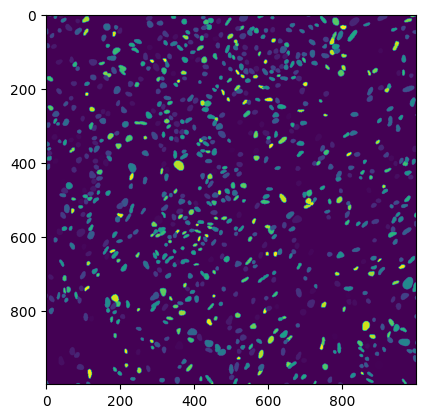

In [27]:
plt.imshow(x[4000:5000, 4000:5000])

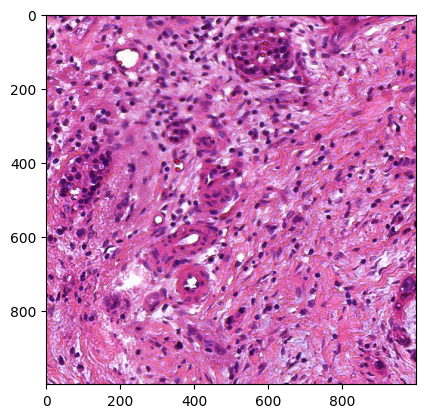

In [28]:
plt.imshow(a.uns['rescaled_he']['1X_trimmed'][4000:5000, 4000:5000])

In [29]:
a.uns['nuclei_segmentation_1X_trimmed'] = x

In [36]:
props = regionprops_table(x, properties=('label', 'centroid'))
props = pd.DataFrame(props)
props = props.set_index('label')
props = props.astype(int)
props.columns = ['row', 'col']
props

,row,col
label,,
1,9377,9721
2,4487,11055
3,4481,2870
4,6668,7265
5,4689,2637
...,...,...
120253,13463,2488
120254,4890,8467
120255,14661,8145


In [37]:
a.uns['segmented_nuclei_coords'] = props

In [38]:
a.write_h5ad('../data/pdac/HT270P1-S1H1U1/adata.h5ad')